In [1]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org scikit-learn

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Parâmetros do problema
num_clients = 495
max_access_points = 30
grid_size = 400  # Tamanho do centro de convenções
max_distance = 85  # Distância máxima entre cliente e ponto de acesso
used_distance = 80
access_point_capacity = 54  # Capacidade máxima de cada ponto de acesso em Mbps
lambda_exposure = 1  # Coeficiente de exposição (sinal nominal do PA)
gamma_decay = 1  # Fator de decaimento ao quadrado

In [3]:
# Função para ler dados do arquivo CSV e normalizar coordenadas
def read_and_normalize_data(csv_file):
    # Ler arquivo CSV
    df = pd.read_csv(csv_file, header=None, sep=',', names=['client_x', 'client_y', 'client_demand'])

    # Extrair coordenadas dos clientes
    client_coordinates = df[['client_x', 'client_y']].values
    
    # Normalizar coordenadas para a escala do grid_size
    client_coordinates = client_coordinates / df[['client_x', 'client_y']].max().max() * grid_size
    
    # Extrair consumo de banda dos clientes
    bandwidth_demands = df['client_demand'].values

    # # Normalizar consumo de banda para estar entre 0 e 1
    # bandwidth_demands = df['client_demand'].values / df['client_demand'].max()

    return client_coordinates, bandwidth_demands

In [4]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')


In [5]:
import math

class Client:
    def __init__(self,id, x, y, banda):
        self.id = id
        self.x = x
        self.y = y
        self.banda = banda
        self.pa = None

class PontoAcesso:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.capacidade = 54
        self.usuarios_conectados = []
    
    def __repr__(self):
        return f"PontoAcesso(x={self.x}, y={self.y}, capacidade={self.capacidade}, usuarios_conectados={self.usuarios_conectados})"

class Solution:

    def __init__(self, pas : dict, clients: list) -> None:
        self.pas = pas
        self.clients = clients

In [6]:
# Solution methods    
def try_connect_user(self, id: str, client: Client) -> bool:
    if self.pas[id].try_connect_user(client, self):
        self.clients[client.id].pa = id
        return True
    return False
Solution.try_connect_user = try_connect_user

def disconnect_user(self, id: str, client: Client) -> bool:
    if self.pas[id].disconnect_user(client):
        self.clients[client.id].pa = None
        return True
    return False
Solution.disconnect_user = disconnect_user

def active_access_point(self) -> int:
    counter = 0
    for value in self.pas.values():
        if len(value.usuarios_conectados) > 0:
            counter += 1
    
    return counter
Solution.active_access_point = active_access_point

def total_distance(self) -> float:
    total_distance = 0
    for value in self.pas.values():
        for client in value.usuarios_conectados:
            total_distance += math.dist([value.x, value.y], [client.x, client.y])
    return total_distance
Solution.total_distance = total_distance

def add_access_point(self, pa: PontoAcesso) -> True:
    pas_qtty = len(self.pas.keys())
    if pas_qtty == 30:
        return False
    
    self.pas[str(pas_qtty)] = pa
Solution.add_access_point = add_access_point

def is_valid_solution(self) -> bool:
    connected_users = [
        user
        for user in self.clients
        if user.pa is not None
    ]

    return (len(connected_users)/ num_clients) > 0.98
Solution.is_valid_solution = is_valid_solution

In [7]:
# Client methods
def total_exposure(self, solution: Solution) -> float:
        total = 0
        for pa in solution.pas.values():
            total += (lambda_exposure / (math.dist([pa.x, pa.y], [self.x, self.y]) ** gamma_decay)) if math.dist([pa.x, pa.y], [self.x, self.y]) != 0 else lambda_exposure
        return total
Client.total_exposure = total_exposure

In [8]:
# PontoAcesso methods
def try_connect_user(self, client: Client, solution: Solution) -> bool:
    if self.capacidade < client.banda or self.distance(client.x, client.y) > 85 or client.total_exposure(solution) < 0.05 * lambda_exposure:
        return False

    self.capacidade = self.capacidade - client.banda
    self.usuarios_conectados.append(client)
    return True
PontoAcesso.try_connect_user = try_connect_user
    
def is_active(self) -> bool:
    return len(self.usuarios_conectados) > 0
PontoAcesso.is_active = is_active

def users_connected(self) -> int:
    return len(self.usuarios_conectados)
PontoAcesso.users_connected = users_connected

def disconnect_user(self, client: Client) -> None:
    if client in self.usuarios_conectados:
        self.usuarios_conectados.remove(client)
        self.capacidade = self.capacidade + client.banda
        client.pa = None
PontoAcesso.disconnect_user = disconnect_user

def distance(self, x: float, y: float) -> float:
    return math.dist([x, y], [self.x, self.y])
PontoAcesso.distance = distance

In [9]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
]

## Heurística Construtiva   

In [10]:
import numpy as np
from sklearn.cluster import KMeans

# Função para realizar o K-means e adicionar PAs
def add_pontos_acesso_with_kmeans(clients, num_clusters):
    # Extrair coordenadas dos clientes
    coordinates = np.array([[client.x, client.y] for client in clients])

    # Aplicar K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coordinates)
    centroids = kmeans.cluster_centers_

    # Adicionar PAs nos centroides dos clusters
    pas = {}
    for i, centroid in enumerate(centroids):
        pas[str(i)] = PontoAcesso(id=str(i), x=centroid[0], y=centroid[1])

    return pas

# Função principal para encontrar a solução
def find_solution(clients, max_pas=20):
    num_clusters = 1
    solution = None

    while num_clusters <= max_pas:
        pas = add_pontos_acesso_with_kmeans(clients, num_clusters)
        solution = Solution(pas=pas, clients=clients)

        # Tentar conectar todos os clientes aos PAs
        for client in clients:
            connected = False
            for pa in pas.values():
                if solution.try_connect_user(pa.id, client):
                    connected = True
                    break

        # Verificar se a solução é válida
        if solution.is_valid_solution():
            return solution

        num_clusters += 1

    return None

solution = find_solution(clients)
if solution:
    print(f"Solution found with {len(solution.pas)} PAs.")
else:
    print("No valid solution found.")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid

Solution found with 10 PAs.


In [11]:
print(solution.total_distance())

22990.080503236495


In [12]:
import random 

n = 30
sample_clients = random.sample(clients, n)
pas_dict = {}
steps = int(grid_size/used_distance)
t = 0
for i in range(0, steps):
    for n in range (0, steps):
       pas_dict[str(t)] =  PontoAcesso(str(t), (i)*used_distance, (n)*used_distance)
       t += 1

In [13]:
solution = Solution(pas_dict, clients)

In [14]:
print(solution.clients)

[<__main__.Client object at 0x000001723E083190>, <__main__.Client object at 0x000001723DBA5FD0>, <__main__.Client object at 0x000001723DAF6910>, <__main__.Client object at 0x000001723B6F0AD0>, <__main__.Client object at 0x0000017237E0B910>, <__main__.Client object at 0x00000172391CE250>, <__main__.Client object at 0x000001723BCDBC50>, <__main__.Client object at 0x000001723E0D6450>, <__main__.Client object at 0x000001723E0D52D0>, <__main__.Client object at 0x0000017237E09C10>, <__main__.Client object at 0x000001723E0D7FD0>, <__main__.Client object at 0x000001723E0D6350>, <__main__.Client object at 0x000001723E0D5C10>, <__main__.Client object at 0x000001723E0D5D90>, <__main__.Client object at 0x000001723E0D7B10>, <__main__.Client object at 0x000001723DB31850>, <__main__.Client object at 0x000001723E089310>, <__main__.Client object at 0x000001723DD8E1D0>, <__main__.Client object at 0x000001723DD0DAD0>, <__main__.Client object at 0x000001723E0CB3D0>, <__main__.Client object at 0x000001723E

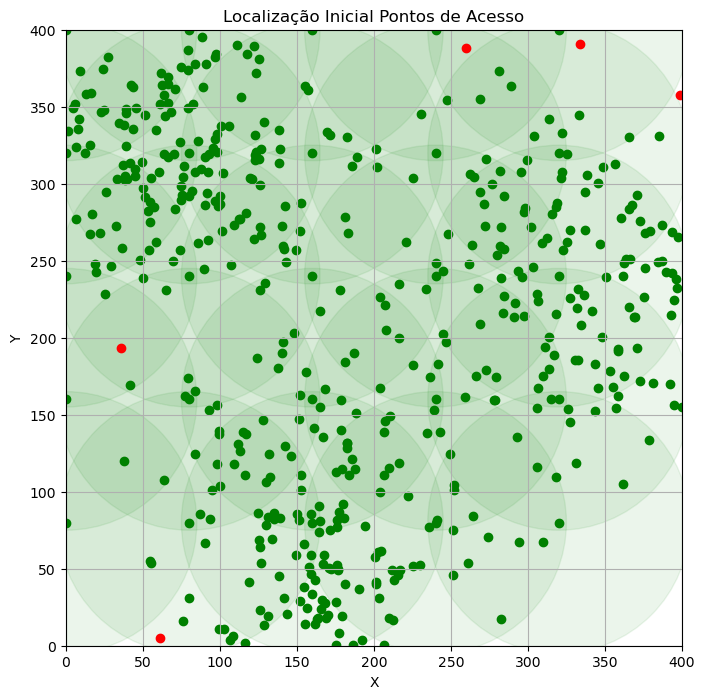

In [15]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in solution.pas.items():
    x, y = mapear_coordenadas(valor.x, valor.y)
    plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
    circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
    plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in solution.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'green' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor)  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title('Localização Inicial Pontos de Acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [16]:
import copy
temp_solution = copy.deepcopy(solution)
def initial_solution(solution) -> Solution:
    temp_solution = copy.deepcopy(solution)
    remaining_pas = max_access_points - len(temp_solution.pas.keys())
    for client in temp_solution.clients:
        counter = 0
        size_pas = len(temp_solution.pas.keys())
        index = random.randrange(0, size_pas)

        for client in temp_solution.clients:
            for pa in temp_solution.pas.values():
                if client.pa is None and temp_solution.try_connect_user(pa.id, client):
                   break
            if client.pa is None and remaining_pas > 0:
                pa_t = len(temp_solution.pas.keys())
                temp_solution.add_access_point(PontoAcesso(str(pa_t), client.x, client.y))
                size_pas = len(temp_solution.pas.keys())
                temp_solution.try_connect_user(str(pa_t), client)
                remaining_pas -= 1

    return temp_solution


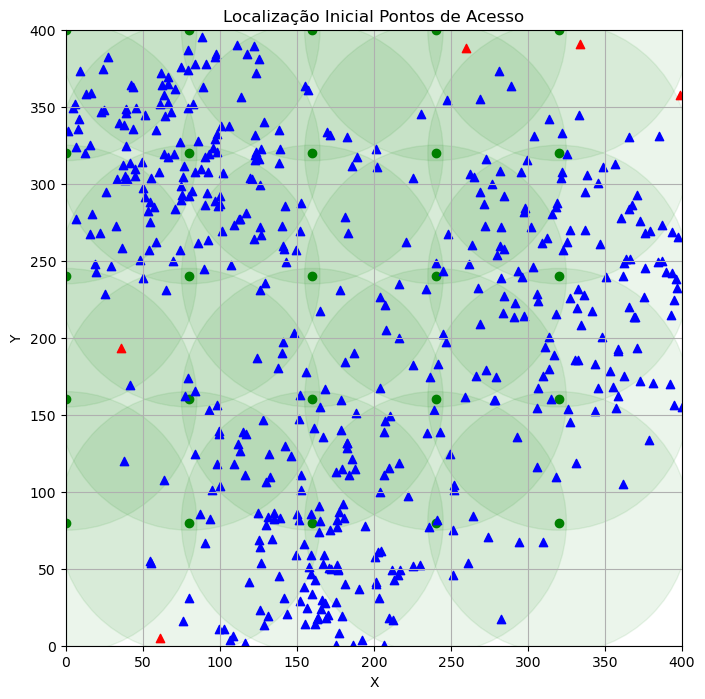

In [17]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in temp_solution.pas.items():
    x, y = mapear_coordenadas(valor.x, valor.y)
    plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
    circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
    plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in temp_solution.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title('Localização Inicial Pontos de Acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [18]:
# for client in temp_solution.clients:
#     print(client.pa)

print(temp_solution.pas)

{'0': PontoAcesso(x=0, y=0, capacidade=54, usuarios_conectados=[]), '1': PontoAcesso(x=0, y=80, capacidade=54, usuarios_conectados=[]), '2': PontoAcesso(x=0, y=160, capacidade=54, usuarios_conectados=[]), '3': PontoAcesso(x=0, y=240, capacidade=54, usuarios_conectados=[]), '4': PontoAcesso(x=0, y=320, capacidade=54, usuarios_conectados=[]), '5': PontoAcesso(x=80, y=0, capacidade=54, usuarios_conectados=[]), '6': PontoAcesso(x=80, y=80, capacidade=54, usuarios_conectados=[]), '7': PontoAcesso(x=80, y=160, capacidade=54, usuarios_conectados=[]), '8': PontoAcesso(x=80, y=240, capacidade=54, usuarios_conectados=[]), '9': PontoAcesso(x=80, y=320, capacidade=54, usuarios_conectados=[]), '10': PontoAcesso(x=160, y=0, capacidade=54, usuarios_conectados=[]), '11': PontoAcesso(x=160, y=80, capacidade=54, usuarios_conectados=[]), '12': PontoAcesso(x=160, y=160, capacidade=54, usuarios_conectados=[]), '13': PontoAcesso(x=160, y=240, capacidade=54, usuarios_conectados=[]), '14': PontoAcesso(x=160, 

In [19]:
# initial_solution()

In [20]:
def check_demand_coverage(solution: Solution):
    covered_clients = 0
    for key, value in solution.pas.items():
        covered_clients += value.users_connected()

    counter = 0
    for client in solution.clients:
        if client.pa is not None:
            counter += 1
    client_cvg_ratio = counter / num_clients
    coverage_ratio = covered_clients / num_clients
    return client_cvg_ratio > 0.98

In [21]:
print(check_demand_coverage(temp_solution))

True


In [22]:
# Ler dados do arquivo CSV e normalizar coordenadas
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
len(client_coordinates), len(bandwidth_demands)

(495, 495)

In [23]:
# Função objetivo 1: minimizar o número de pontos de acesso
def objective_function_1(solution: Solution):
    return solution.active_access_point(), solution.total_distance()

# Função objetivo 2: minimizar a distância entre pontos de acesso e clientes
def objective_function_2(solution: Solution):
    return solution.active_access_point(), solution.total_distance()

In [24]:
objective_function_1(temp_solution)

(0, 0)

In [25]:
objective_function_2(temp_solution)

(0, 0)

In [26]:
import copy

# Explorar vizinhança (swap)
def explore_neighborhood_swap(solution: Solution):
    new_solution = copy.deepcopy(solution)
    i = random.randint(0, len(new_solution.pas.keys()) - 1)
    disconnected_users = []
    for user_connected in new_solution.pas[str(i)].usuarios_conectados:
        new_solution.disconnect_user(str(i), user_connected)
        disconnected_users.append(user_connected)
    
    for user in disconnected_users:
        for pas in new_solution.pas.values():
            if pas.is_active() and new_solution.try_connect_user(pas.id, user):
                disconnected_users.remove(user)
                break
    return new_solution

def explore_neighborhood_exchange(solution: Solution):
    temp_solution = copy.deepcopy(solution)
    users_connected = math.inf
    for pa in temp_solution.pas.values():
        if pa.is_active() and len(pa.usuarios_conectados) < users_connected:
            least_used_pa = pa.id
    
    disconnected_users = temp_solution.pas[least_used_pa].usuarios_conectados
    for user in disconnected_users:
        temp_solution.disconnect_user(least_used_pa, user)

    for user in disconnected_users:
        for pa in temp_solution.pas.values():
            if temp_solution.try_connect_user(pa.id, user):
                break
    return temp_solution

# Explorar vizinhança (inserção)
def explore_neighborhood_insert(solution: Solution):
    new_solution = copy.deepcopy(solution)
    unatendent_clients = [
        client
        for client in new_solution.clients
        if client.pa is None
    ]
    
    
    if len(unatendent_clients) > 0:
        selected_client = random.choice(unatendent_clients)
        selected_pa = random.choice(list(new_solution.pas.keys()))

        new_solution.pas[str(selected_pa)].x = selected_client.x
        new_solution.pas[str(selected_pa)].y = selected_client.y

        for client in new_solution.pas[selected_pa].usuarios_conectados:
            new_solution.disconnect_user(selected_pa, client)
            unatendent_clients.append(client)

        for user in unatendent_clients:
            for pas in new_solution.pas.values():
                if pas.is_active() and new_solution.try_connect_user(pas.id, user):
                    unatendent_clients.remove(user)
                    break

        return new_solution
    return solution

# Explorar vizinhança (reversão)
# def explore_neighborhood_reverse(solution: Solution):
#     new_solution = copy.deepcopy(solution)
#     i1, i2 = random.sample(range(max_access_points), 2)  # Seleciona dois índices aleatórios
#     new_solution['y'][i1], new_solution['y'][i2] = new_solution['y'][i2], new_solution['y'][i1]  # Troca os estados dos pontos de acesso
#     return new_solution

In [27]:
import copy

def shake(x: Solution, k: int):
    
    y = copy.deepcopy(x)
    
    if k == 3:             # apply not operator in one random position
        y = explore_neighborhood_insert(y)
        
    elif k == 2:           # apply not operator in two random positions        
        y = explore_neighborhood_exchange(y)
        
    elif k == 1:           # apply not operator in three random positions
        y = explore_neighborhood_swap(y)      
    
    return y

In [28]:
def local_search(solution: Solution):
    new_solution = copy.deepcopy(solution)
    client = random.choice(new_solution.clients)

    nearest_pa_distance = math.inf
    nearest_pa_id = -1
    for pa in new_solution.pas.values():
        if pa.is_active() and pa.distance(client.x, client.y) < nearest_pa_distance:
            nearest_pa_distance = pa.distance(client.x, client.y)
            nearest_pa_id = pa.id
    
    if (nearest_pa_id is not client.pa and nearest_pa_distance < max_distance):
        if client.pa is None or new_solution.disconnect_user(client.pa, client):
            new_solution.try_connect_user(nearest_pa_id, client)

    return new_solution

In [29]:
def neighborhoodChange(x, y, k):
    
    if y < x.single_objective_value:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

In [44]:
# Função RVNS (Reactive Variable Neighborhood Search) generalizada
def rvns(max_iterations, max_iterations_no_improve, objective_function):
    # Inicializar solução aleatória
    clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
    ]   
    
    import random 

    pas_dict = {}
    steps = int(grid_size/used_distance)
    t = 0
    for i in range(0, steps):
        for n in range (0, steps):
            pas_dict[str(t)] =  PontoAcesso(str(t), (i)*used_distance, (n)*used_distance)
            t += 1

    temp_solution = Solution(pas_dict, clients)
    solution = initial_solution(temp_solution)
    best_solution = copy.deepcopy(solution)
    best_fitness = objective_function(solution)

    iteration = 0
    k_max = 3
    new_solution = copy.deepcopy(best_solution)
    while iteration < max_iterations:
        iteration += 1
        iteration_no_improve = 0
        k = 1

        while k <= k_max:
            # print('K ', k)
            iteration_no_improve += 1
            new_solution = local_search(new_solution)
            new_solution = shake(new_solution, k)
            # Explorar vizinhança
            #new_solution, k = neighborhood_function(solution)

            # Avaliar a nova solução
            new_fitness = objective_function(new_solution)
            if k%1000 == 0: print(best_fitness)
            # Aceitar ou rejeitar a nova solução
            if (new_fitness < best_fitness) and check_demand_coverage(new_solution):
                k = 1
                best_solution = copy.deepcopy(new_solution)
                best_fitness = new_fitness
                iteration_no_improve = 0  # Resetar contador de iterações sem melhora
            else: 
                k += 1
        # Atualizar solução com a melhor encontrada
        solution = copy.deepcopy(best_solution)

    return best_solution, best_fitness

In [31]:
max_iterations_min_pas = 8000
a, b = rvns(max_iterations_min_pas, 10, objective_function_1)


K  1
(27, 28967.757966077683)
K  1
(27, 28885.64911186066)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 28835.832416980793)
K  3
(27, 28835.832416980793)
K  1
(27, 28835.832416980793)
K  2
(27, 2

In [32]:
print(check_demand_coverage(a))
counter = 0
for client in a.clients:
    if client.pa is not None:
        counter += 1
client_cvg_ratio = counter / num_clients

print(f'{client_cvg_ratio*100}% clientes conectados')

True
98.18181818181819% clientes conectados


In [33]:
t = a

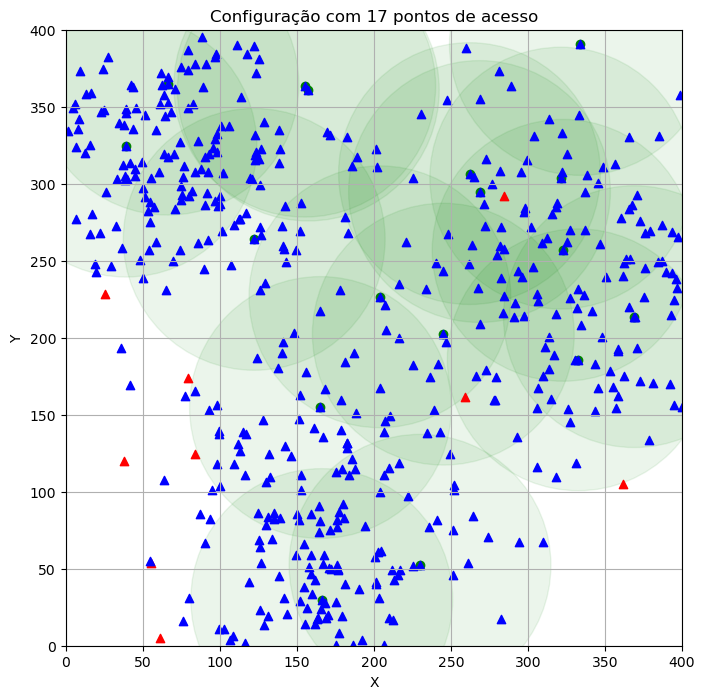

In [34]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in t.pas.items():
    if(valor.is_active()):
        x, y = mapear_coordenadas(valor.x, valor.y)
        plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
        circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
        plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in t.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title(f'Configuração com {t.active_access_point()} pontos de acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [35]:
max_iterations_min_distance = 8000
c, d = rvns(max_iterations_min_distance, 10, objective_function_2)


K  1
(27, 28967.757966077683)
K  1
(26, 28887.27808755527)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 28560.08573117304)
K  1
(26, 28560.08573117304)
K  2
(26, 28560.08573117304)
K  3
(26, 285

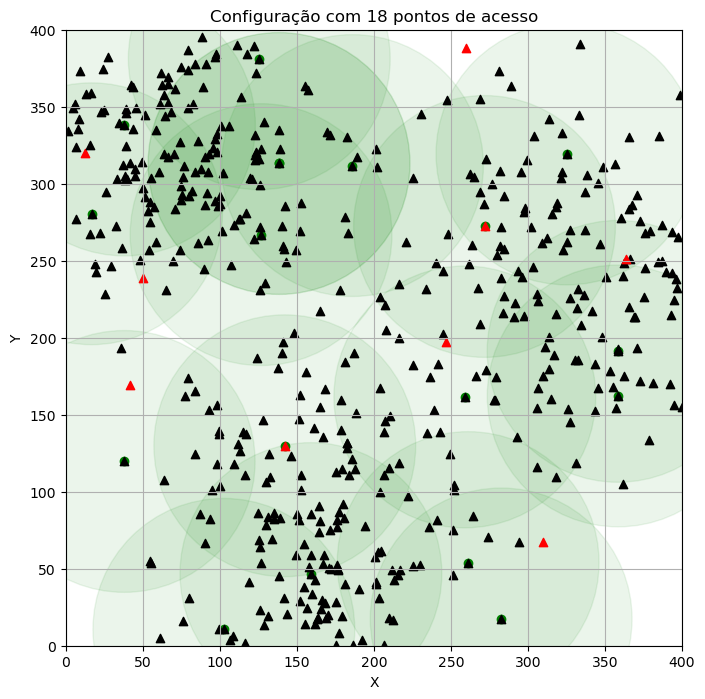

In [36]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in c.pas.items():
    if(valor.is_active()):
        x, y = mapear_coordenadas(valor.x, valor.y)
        plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
        circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
        plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in c.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'black' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title(f'Configuração com {c.active_access_point()} pontos de acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [37]:
print(f'Distância Total: {d[1]} unidades')

Distância Total: 64558.06077702737 unidades


## Problema BiObjetivo

In [38]:
def plot_frontier(best_weights_list, best_sums_list, best_sols_list, colors):
    # Extrair os valores x e y dos pontos
    # x = [ponto[0] for ponto in best_sols_list]
    # y = [ponto[1] for ponto in best_sols_list]
    # legends = ['Fronteira 1', None, None, None, None, 
    #            'Fronteira 2', None, None, None, None,
    #            'Fronteira 3', None, None, None, None,
    #            'Fronteira 4', None, None, None, None,
    #            'Fronteira 5', None, None, None, None,]

    plt.figure(figsize=(8, 6))
    for i in range(5):
        for ponto in range(10*i, (10*i)+10):
            plt.scatter(best_sols_list[ponto][0], best_sols_list[ponto][1], c=colors[i], label=('Fronteira '+str(i+1) if ponto%10 == 0 else '_nolegend_'))
    plt.title('Número de PAs por Distância Total')
    plt.xlabel('Número de PAs')
    plt.ylabel('Distância Total')
    plt.legend()
    plt.grid(True)
    plt.show()

In [39]:
# Soma Ponderada

# NUM PAS: b[0] ou d[1]
# DISTANCIA: b[1] ou d[1]

# resultados temporários
# best_sum = 1*d[0] + 1*d[1]
# best_weights = [1, 1]
# best_sol = [d[0], d[1]]
# lista dos resultados por iteração (vão ser 5 resultados/pontos por fronteira)
best_weights_list = []
best_sums_list = []
best_sols = []
colors = ["blue", "red", "green", "black", "orange"]

In [45]:
# criar 5 vezes uma fronteira de soluções não dominadas
for frontier in range(5):
    # 10 iterações com 2 otimizações em cada - se aumentar o nº preciso mudar a lógica em plot_frontier)
    print('FRONTEIRA ', frontier)
    for i in range(0,20,2):
        # pesos fazem par assim: 0 - 2; 1 - 3
        weights = list(np.random.uniform(low=0.1, high=1, size=(2)))
        weights.append(1-weights[0])
        weights.append(1-weights[1])

        a, b = rvns(3000, 5, objective_function_1)
        c, d = rvns(3000, 5, objective_function_2)

        weighted_sum1 = weights[0]*b[0] + weights[2]*b[1]
        weighted_sum2 = weights[1]*d[0] + weights[3]*d[1]

        # resultado inicial
        best_sum = 1*b[0] + 1*b[1]
        best_weights = [weights[0], weights[2]]
        best_sol = [b[0], b[1]]

        if weighted_sum1 < best_sum:
            if weighted_sum1 < weighted_sum2:
                best_sum = weighted_sum1
                best_weights = [weights[0], weights[2]]
                best_sol = [b[0],b[1]]
            elif weighted_sum2 <= weighted_sum1:
                best_sum = weighted_sum2
                best_weights = [weights[1], weights[3]]
                best_sol = [d[0],d[1]]
        elif weighted_sum2 < best_sum:
            best_sum = weighted_sum2
            best_weights = [weights[1], weights[3]]
            best_sol = [d[0],d[1]]
        
        best_weights_list.append(best_weights)
        best_sums_list.append(best_sum)
        best_sols.append(best_sol)
        print('ITERAÇÃO ', i)

FRONTEIRA  0
ITERAÇÃO  0
ITERAÇÃO  2
ITERAÇÃO  4
ITERAÇÃO  6
ITERAÇÃO  8
ITERAÇÃO  10
ITERAÇÃO  12
ITERAÇÃO  14
ITERAÇÃO  16
ITERAÇÃO  18
FRONTEIRA  1
ITERAÇÃO  0
ITERAÇÃO  2
ITERAÇÃO  4
ITERAÇÃO  6
ITERAÇÃO  8
ITERAÇÃO  10
ITERAÇÃO  12
ITERAÇÃO  14
ITERAÇÃO  16
ITERAÇÃO  18
FRONTEIRA  2
ITERAÇÃO  0
ITERAÇÃO  2
ITERAÇÃO  4
ITERAÇÃO  6
ITERAÇÃO  8
ITERAÇÃO  10
ITERAÇÃO  12
ITERAÇÃO  14
ITERAÇÃO  16
ITERAÇÃO  18
FRONTEIRA  3
ITERAÇÃO  0
ITERAÇÃO  2
ITERAÇÃO  4
ITERAÇÃO  6
ITERAÇÃO  8
ITERAÇÃO  10
ITERAÇÃO  12
ITERAÇÃO  14
ITERAÇÃO  16
ITERAÇÃO  18
FRONTEIRA  4
ITERAÇÃO  0
ITERAÇÃO  2
ITERAÇÃO  4
ITERAÇÃO  6
ITERAÇÃO  8
ITERAÇÃO  10
ITERAÇÃO  12
ITERAÇÃO  14
ITERAÇÃO  16
ITERAÇÃO  18


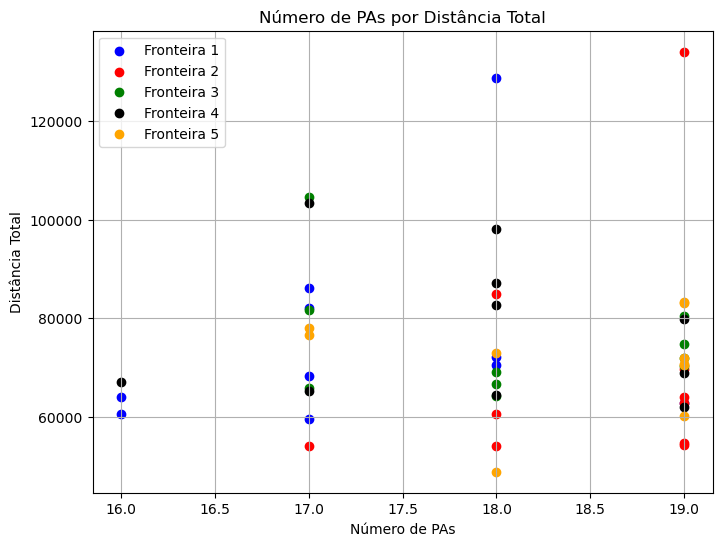

In [46]:
plot_frontier(best_weights_list, best_sums_list, best_sols, colors)

In [47]:
# Normalizar os dados das soluções
# scaler = MinMaxScaler()
# best_sols_normalized = scaler.fit_transform(best_sols)

# plot_frontier(best_weights_list, best_sums_list, best_sols_normalized, colors)